Precipitation Metrics (consecutive dry days, rolling 5-day precip accumulation, return period)

In [2]:
! pip install xclim

In [38]:
%matplotlib inline
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt
import os
import pandas as pd
from datetime import datetime, timedelta, date

import dask
import dask.array as dda
import dask.distributed as dd

# rhodium-specific kubernetes cluster configuration
import rhg_compute_tools.kubernetes as rhgk

In [39]:
client, cluster = rhgk.get_big_cluster()
cluster.scale(30)

In [2]:
client

In [84]:
cluster.close()

In [60]:
def pull_ERA5_variable(filevar, variable):
    filenames = []
    
    for num_yrs in range(len(yrs)):
        filename = '/gcs/impactlab-data/climate/source_data/ERA-5/{}/daily/netcdf/v1.3/{}_daily_{}-{}.nc'.format(filevar, filevar, yrs[num_yrs], yrs[num_yrs])
        filenames.append(filename)
    
    era5_var = xr.open_mfdataset(filenames, 
                               concat_dim='time', combine='by_coords')
    
    var_all = era5_var[variable]
    
    return var_all

In [61]:
yrs = np.arange(1995,2015) 

In [62]:
da = pull_ERA5_variable('pr', 'tp')

In [4]:
import xclim as xc
from xclim.core.calendar import convert_calendar

# remove leap days and convert calendar to no-leap
da = convert_calendar(da, 'noleap')

In [64]:
da_mm = da*1000
da_mm.attrs["units"] = "mm/day"

In [66]:
da_mm = da_mm.persist()

Calculate the max number of consecutive dry days per year. Use the threshold value for the wet day frequency correction

In [5]:
dry_days = xc.indicators.atmos.maximum_consecutive_dry_days(da_mm, thresh=0.0005, freq='YS')

In [68]:
dry_days = dry_days.compute()

In [ ]:
#dry_days.sel(latitude=50.0, longitude=0.0).plot()

In [69]:
avg_dry_days = dry_days.mean(dim='time').compute()

In [ ]:
avg_dry_days.plot(robust=True)

In [48]:
from matplotlib import cm
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [81]:
def plot_average_dry_days(da, years, fname):    
    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.Robinson())
    cmap = cm.pink_r 

    da.plot(
        ax=ax,
        cmap=cmap,
        transform=ccrs.PlateCarree(),
        cbar_kwargs={'shrink': 0.8, 'pad': 0.02, "label": "# of days"},
        vmin=0,
        vmax=180,
    )

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.set_title("Mean number of consecutive dry days annually ({})".format(years))
    
    plt.savefig(fname, dpi=600, bbox_inches='tight')

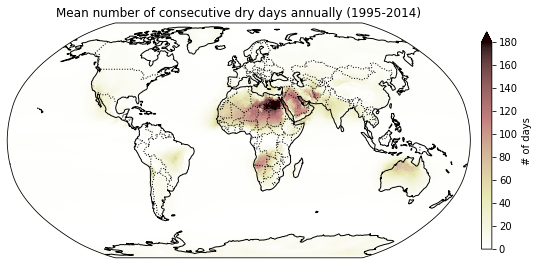

In [82]:
plot_average_dry_days(avg_dry_days, '1995-2014', 'avg_dry_days_era5')

Calculate the highest precipitation amount cumulated over a 5-day moving window

In [49]:
max_5day_dailyprecip = xc.indicators.icclim.RX5day(da_mm, freq='YS')

# there is a different function for a n-day moving window

In [50]:
max_5day_dailyprecip = max_5day_dailyprecip.compute()

In [53]:
avg_5day_dailyprecip = max_5day_dailyprecip.mean(dim='time').compute()

In [ ]:
avg_5day_dailyprecip.plot()

In [51]:
def plot_average_5day_max_precip(da, years, fname):    
    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.Robinson())
    cmap = cm.GnBu

    da.plot(
        ax=ax,
        cmap=cmap,
        transform=ccrs.PlateCarree(),
        cbar_kwargs={'shrink': 0.8, 'pad': 0.02, "label": "5-day accumulated precip (mm)"},
        vmin=0,
        vmax=250,
    )

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.set_title("Maximum annual 5-day rolling precipitation accumulation ({})".format(years))
    
    plt.savefig(fname, dpi=600, bbox_inches='tight')

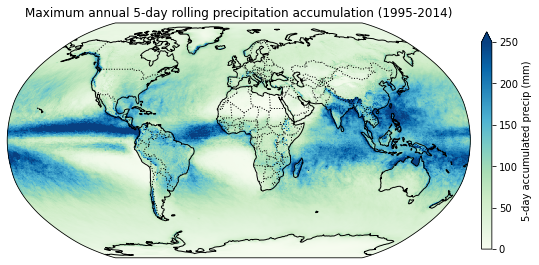

In [54]:
plot_average_5day_max_precip(avg_5day_dailyprecip, '1995-2014', 'avg_max_5day_precip_era5')

Comparing difference of mean with nans and mean without taking into account nans

In [ ]:
avg_5day_dailyprecip = max_5day_dailyprecip.mean(dim='time', skipna=True).compute()

In [ ]:
avg_5day_dailyprecip

In [ ]:
plot_average_5day_max_precip(avg_5day_dailyprecip, '1995-2014')

In [ ]:
max_5day_dailyprecip.sel(latitude=-89.0, longitude=0.0).plot()

Basics for calculating the return period of daily precipitation. More testing needed as it blows up currently.

In [ ]:
def calculate_return(da, return_interval):
    '''
    calculate return period of daily precip data per grid point
    '''
    # Sort data smallest to largest
    sorted_data = da.sortby(da, ascending=True).compute()
    
    # Count total obervations
    n = sorted_data.shape[0]
    
    # Compute rank position
    rank = np.arange(1, 1 + n)
    
    # Calculate probability
    probability = (n - rank + 1) / (n + 1)
    
    # Calculate return - data are daily to then divide by 365?
    return_year = (1 / probability)
    
    # Round return period
    return_yr_rnd = np.around(return_year, decimals=1)
    
    # identify daily precip for specified return interval
    indices = np.where(return_yr_rnd == return_interval)
    
    # Compute over daily accumulation for the X return period
    mean_return_period_value = sorted_data[indices].mean().compute()

    return(mean_return_period_value)

In [ ]:
da_grid_cell = da.sel(latitude=lat, longitude=lon)
da_grid_cell

In [ ]:
# applyufunc --> this applies a function to a single grid cell

In [ ]:
return_values = []

for ilat in range(0, len(da.latitude)):
    for ilon in range(0, len(da.longitude):
        # create array to store lon values per lat
        values_per_lat = []
        # select da per grid cell
        da_grid_cell = da.sel(latitude=latitude[ilat], longitude=longitude[ilon])
        # compute return period value & append
        mean_return_value = calculate_return(da_grid_cell, 5.0)
        values_per_lat.append(mean_return_value)
    
    # for each latitude save all longitude values
    return_values.append(values_per_lat)

In [ ]:
return_values

In [ ]:
for lat in da.latitude:
    for lon in da.longitude:
        da_grid_cell = da.sel(latitude=lat, longitude=lon)
        
        mean_return_value = calculate_return(da_grid_cell, 5.0)       

Breakdown of per step testing of return period

In [ ]:
da_test = da.sel(latitude=75.0, longitude=18.0).persist()
da_test

In [ ]:
mean = calculate_return(da_test, 5.0)
mean

In [ ]:
sorted_data = da_test.sortby(da_test, ascending=True).compute()
sorted_data

In [ ]:
n = sorted_data.shape[0]
n

In [ ]:
rank = np.arange(1, 1 + n) #  sorted_data.insert(0, 'rank', range(1, 1 + n))
rank

In [ ]:
probability = (n - rank + 1) / (n + 1)
probability

In [ ]:
return_year = (1 / probability)
return_year

In [ ]:
return_yr_rnd = np.around(return_year, decimals=1)
return_yr_rnd[5679]

In [ ]:
indices = np.where(return_yr_rnd == 5.0)
indices

In [ ]:
sorted_data[indices].mean().compute()

In [ ]:
sorted_test = np.sort(da_test, axis=0)


In [ ]:
sorted_test = xr.DataArray(sorted_test)
sorted_test